# NHST: Foundations and Practice

### Sean Trott

### CSS Bootcamp

In [1]:
## Imports
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

# High-level learning outcomes of this week

##### [Null Hypothesis Significance Testing (NHST)](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing)

- **Explain** the theoretical foundations  
- **Implement** a t-test in Python  
- **Evaluate** the result of a given test

##### [Linear regression](https://en.wikipedia.org/wiki/Linear_regression): 

- **Implement** using Python
- **Interpret** coefficients, **examine** residuals, and **predict** new data  

##### [Beyond linear regression](https://en.wikipedia.org/wiki/Generalized_linear_model): 

- **Explain** the motivation for mixed/multilevel models  
- **Implement** other families of regression models (e.g., logistic regression)

# Today's focus

- **Explain** the theoretical foundations of NHST   
- **Implement** a t-test in Python.  
- **Evaluate** the result of a t-test with respect to a research hypothesis.   

# Part 0: Review

The last session had several **key takeaways**:

- **Sampling error** means that a sample statistic (e.g., $\bar{X}$) rarely equals the population parameter (e.g., $\mu$).  
- However, $\bar{X}$ is an **unbiased estimator**: 
 - The **Central Limit Theorem** states that as $n$ increases, the distribution of **sample means** becomes increasingly normal. 
 - The mean of this distribution is equal to $\mu$.  
- We can use this sampling distribution as our **null distribution** for NHST. 

# Part 1: Introduction to NHST

[NHST](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing) is an approach to inferential statistics which involves making a **decision** about **rejecting** or **failing to reject** the null hypothesis.

We'll break this topic into several components:  

- Intuition: null vs. alternate hypotheses  
- Connecting to sampling distributions  
- The **z-test**: our first hypothesis test

## 1a. Building intuition

Consider the following scenario:

> A researcher is interested in whether a new test prep course improves SAT performance. Somehow, we already know population-level mean: it's $520$. We also know that population $\sigma = 5$. 

> They randomly assign 10 students to take the course, who then take the SAT. The researcher calculates the average SAT score for those students: it's $530$. 

Did the test prep work? **How would we know?**

## High-level hypothesis space

Fundamentally, we're asking whether that **sample mean** ($\bar{X} = 530$) is:

- Higher than the **population mean** ($\mu = 520$)?
- No different (or perhaps lower) than the **population mean** ($\mu = 520$)?

I.e., is it any different from what we'd expect if they *hadn't* taken the course?

## Check-in: Descriptively, $\bar{X} > \mu$. Why can't we just conclude that the test prep worked?

### Describing the hypothesis space

These possibilities correspond to distinct **hypotheses**:

- $H_0$ (**Null Hypothesis**): The test prep course did *not* improve performance (the sample is not from a different "population").  
- $H_1$ (**Alternate Hypothesis**): The test prep course *did* improve performance (the sample is from a different "population").

We can express these more formally:

- $H_0: \bar{X} = \mu$  
- $H_1: \bar{X} > \mu$

### Note: one-tailed vs. two-tailed

Hypothesis tests can be either:

- **One-tailed**: I.e., testing a *directional* difference ("The sample mean is *greater* than population mean.")
- **Two-tailed**: I.e., testing *any* difference ("The sample mean is *different* from the population mean.")

This will affect exactly how the **p-value** is calculated––i.e., are you sampling from *both* sides of the distribution, or just one?

### Contending with sampling error

Of course, **sampling error** makes it very likely that $\bar{X} ≠ \mu$.

- This doesn't mean $H_0$ is false!  
- Even two samples drawn from the same population will have different means.  

**How different is truly different?**

## 1b. Connecting to sampling distributions

Key insights:

- [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) states that as $n$ increases, distribution of sample means is increasingly normal.  
- A normal distribution can be **z-scored** and turned into the **standard normal distribution**.  

Because this is a **probability distribution**, we can calculate the *probability* of any given value (e.g., $\bar{X}$) having been sampled from that distribution!

### Using cumulative distribution functions

To calculate this probability, we use a **cumulative distribution function** (or CDF).

- Note: in practice, you won't need to calculate this by hand––most packages will give you a *p-value* automatically.  
- But remember: a *p-value* depends on **which** sampling distribution you're assuming as your null hypothesis.  

#### Defining the standard normal distribution  

In [3]:
s_norm = ss.norm(loc = 0, scale = 1)
s_norm

#### Now, we can use `s_norm.cdf(X)` to calculate $p(≤X)$

**Check-in**: Why is $p(≤X) = .5$?

In [4]:
s_norm.cdf(0)

0.5

In [5]:
s_norm.cdf(1)

0.8413447460685429

#### We can also plot the CDF through some set of points

Text(0, 0.5, 'P(≤X)')

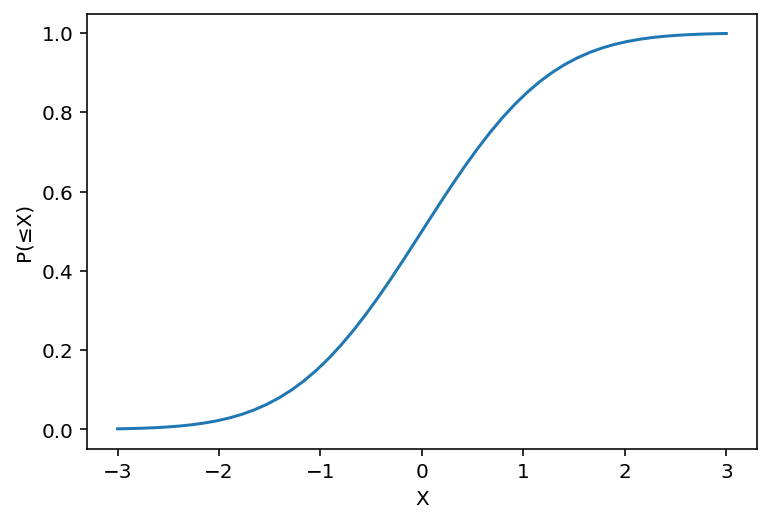

In [6]:
points = np.linspace(-3, 3, 50)
points_cdf = s_norm.cdf(points)
p = plt.plot(points, points_cdf)
plt.xlabel("X")
plt.ylabel("P(≤X)")

## Check-in: How would we calculate $p(>X)$?

#### To calculate $p(>X)$, simply subtract $1 - p(≤X)$

In [7]:
1 - s_norm.cdf(1)

0.15865525393145707

In [8]:
# Normal distribution is *symmetric*
(1 - s_norm.cdf(1)) == s_norm.cdf(-1)

True

## Why does $p$ matter?

This **probability** $p$ tells us the likelihood of having sampled a value *at least as extreme* from our sampling distribution.

Remember: we want to make a **decision** about whether or not to reject the **null hypothesis**.

- If $p$ is very low, we feel more comfortable saying that our sample is unlikely to have come from the original population. 
- But if $p$ is very high, it suggests we did sample from the sampling distribution.

## Probabilistic truth

This notion of scientific truth is a **probabilistic one**.  

Concretely, it gives us: $p(≥\bar{X} | H_0)$.

- $p(≥\bar{X}$ is the probability of obtaining a value at least as large (or as **extreme**) as $\bar{X}$.  
- This is **conditioned** on the null hypothesis ($H_0$) being *true*.

If the null hypothesis was true, what is the likelihood of obtaining a sample mean this extreme by chance?

## 1c. Z-test

Returning to our original example: 

> A researcher is interested in whether a new test prep course improves SAT performance. Somehow, we already know population-level mean: it's $520$. We also know that population $\sigma = 5$. 

> They randomly assign 10 students to take the course, who then take the SAT. The researcher calculates the average SAT score for those students: it's $530$. 

**Did the test work**?

### Step 1: are sample and population mean different?

This is easier to answer:

$\bar{X} - \mu$

In [9]:
diff = 530 - 520
diff

10

### Step 2: setting up our sampling distribution

Recall that our sampling distribution represents the set of **sample means** we'd get if we were sampling from the true population.

Thus, our sampling distribution is *parameterized* by:

- The standard deviation of the population: $\sigma = 5$  
- The size of our sample: $n = 10$

### Calculating the variance of our sampling distribution

The **standard error of the mean** can be obtained with a formula we've already seen:

$\sigma_{\bar{X}} = \frac{\sigma}{\sqrt{n}}$

- $\sigma_{\bar{X}}$ = standard error of the mean.
- $\sigma$ = standard deviation of the population.  
- $n$ = sample size.  

In [10]:
se_mean = 5/math.sqrt(10)
se_mean

1.5811388300841895

### Step 3: Putting it altogether

The whole formula for the **z-test** is given by:

$Z_\bar{X} = \frac{\bar{X} -\mu}{\sigma_{\bar{X}}}$

In [11]:
z = diff / se_mean
z

6.324555320336759

### Finding a p-value

Now that we have a value for $Z_\bar{X}$, we want to know how **likely** it is to obtain a value at least that large. 

And we can use the **standard normal distribution** as our sampling distribution!

In [12]:
pop_dist = ss.norm(loc = 0, scale = 1)
p = 1 - pop_dist.cdf(z)
p

1.269814253745949e-10

## Check-in: Why did we calculate $p(>X)$, rather than $p(<X)$? 

## Check-in: What would we do if we just wanted to know if the population mean was *different* from the sample mean?

## Making a decision

Typically, we set some **decision threshold** ($\alpha$), which reflects our tolerance for a false positive.

- If $p < \alpha$, then we **reject** the null hypothesis.  
- If $p ≥ \alpha$, we **fail to reject** the null hypothesis.

## Check-in: Should we reject the null hypothesis in this case?

## Check-in: Does this mean we're $100\%$ confident that the test prep worked? Why or why not?

## Decisions can be wrong

In [signal detection](https://en.wikipedia.org/wiki/Detection_theory), there's always some possibility that we make the **wrong decision**.

- A **false positive** is when we incorrectly reject the null hypothesis––i.e., there's no "real" effect, but we conclude that there is.  
 - Sometimes called **false alarm** 
- A **false negative** is when we incorrectly *fail* to reject the null––i.e., there is a "real" effect, but we miss it.  
 - Sometimes called **miss**

## Check-in: What's worse, in your opinion––a false positive or false negative?

## False positives in published science

The [replication crisis](https://en.wikipedia.org/wiki/Replication_crisis) has called attention to the prevalence of **false positive results** in published research.

Many causes:  

- [Publication bias ("file drawer problem")](https://en.wikipedia.org/wiki/Publication_bias). 
- ["P-hacking"](https://en.wikipedia.org/wiki/Data_dredging). 

## Check-in: Why can p-hacking lead to false positives?

## P-hacking and false positives

Recall that $\alpha$ is our threshold for rejecting the null hypothesis.

- If $\alpha = .05$, it means that we're accepting a $5\%$ chance of a false positive.  
- And if we run **multiple tests** on the same dataset, this chance can be greatly inflated.  

## Check-in: What's the probability of obtaining at least one false positive result with two tests?

### Answer: $p(≥FP)$ with two tests

- Start out by asking: what's the probability of **no false positives**?  
- Analogy: what's the probability of getting **HH** with two coin tosses?

This is equivalent to:

$p(HH) = p(H)^k$ ... where $k$ is the number of tosses.

In [13]:
## Assuming a fair coin...
.5 ** 2

0.25

### Answer: $p(≥FP)$ with two tests

- We want to know the **complement** of that probability.  
- Analogy: what's the probability of getting **at least one T** with two coin tosses?

To calculate this, we **subtract** the probability of $p(HH)$.  

$p(≥T) = 1 - p(H)^k$

In [14]:
## Assuming a fair coin...
1 - (.5 ** 2)

0.75

### Applying this to hypothesis testing

In [15]:
alpha = .05  ## p(FP) for a given test
num_tests = 2  ## k
p_fp = 1 - (1-alpha)**num_tests 
p_fp

0.09750000000000003

### $p(≥FP)$ gets big quickly!

In [16]:
alpha = .05  ## p(FP) for a given test
num_tests = 10  ## k
p_fp = 1 - (1-alpha)**num_tests 
p_fp

0.4012630607616213

## Conclusion: NHST foundations

- We want to know whether $\bar{X} ≠ \mu$. 
- Because of **sampling error**, we need to account for the probability that a difference this large could've been obtained given the **null hypothesis**.  
- The CLT allows us to make a **probabilistic decision** about whether to reject the null.  
- This decision comes with a caveat: there's always *some* probability of a **false positive** or a **false negative**.

# Part 2: One-sample t-test

## Background: Z-test

A key limitation of the **z-test** is that it assumes we know the **population SD** ($\sigma$). The formula for the standard error of the mean depends on it:

$\sigma_{\bar{X}} = \frac{\sigma}{\sqrt{n}}$

**But this is rarely, if ever, true!**

## One-sample t-test

- As with z-test, we want to compare a **sample mean** ($\bar{X}$) to a population mean ($\mu$).   
- Key difference: We don't know $\sigma$.  

**If we don't know $\sigma$, we can instead use the sampling distribution of $t$.**


## Sampling distribution of $t$

- More appropriately termed a *family* of distributions.  
- Parameterized by **degrees of freedom**, or $df$.  
 
 $df = n - 1$, where $n$ is #observations. 
 

- As $n$ increases, sampling distribution becomes increasingly normal.  

### $t$-distribution in Python

We can use `scipy.stats.t` to access different functions related to the sampling distribution of $t$.  

- `t.rvs`: generate random variates from a given $t$-distribution. 
- `t.pdf`: probability density function for a set of points using a given $t$-distribution.  
- `t.cdf`: cumulative distribution function for a set of points using a given $t$-distribution. 

And more!

### Check-in: What do we notice about the distribution where $df = 1$?

(For comparison, let's also look at the standard normal distribution.)

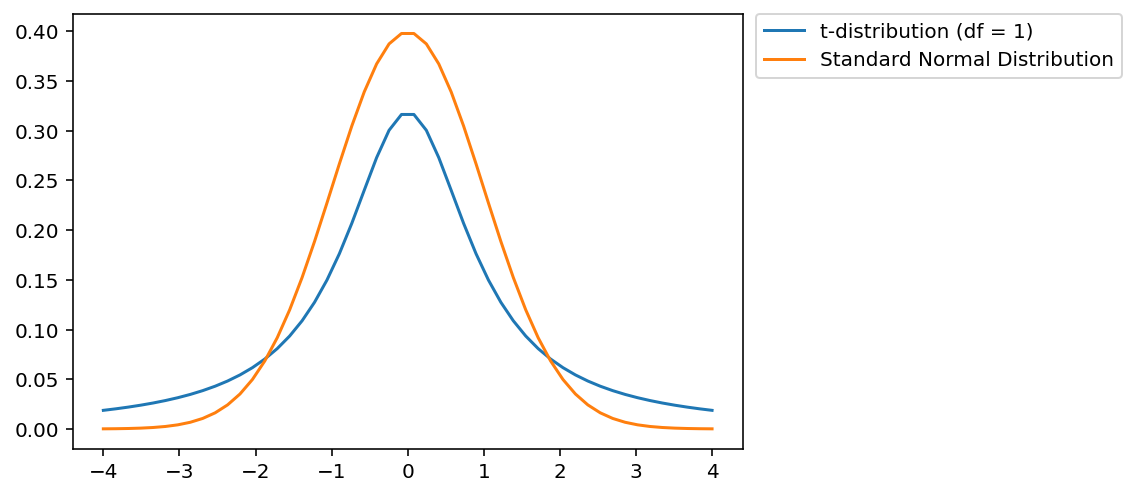

In [29]:
points =  np.linspace(-4, 4, num = 50)
s_norm = ss.norm(loc = 0, scale = 1)
points_pdf_norm = s_norm.pdf(points)
points_pdf =  ss.t.pdf(points, df = 1)
p = plt.plot(points, points_pdf, label = "t-distribution (df = 1)")
p2 = plt.plot(points, points_pdf_norm, label = "Standard Normal Distribution")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

### Check-in: What do we notice about the distribution where $df = 10$?

(For comparison, let's also look at the standard normal distribution.)

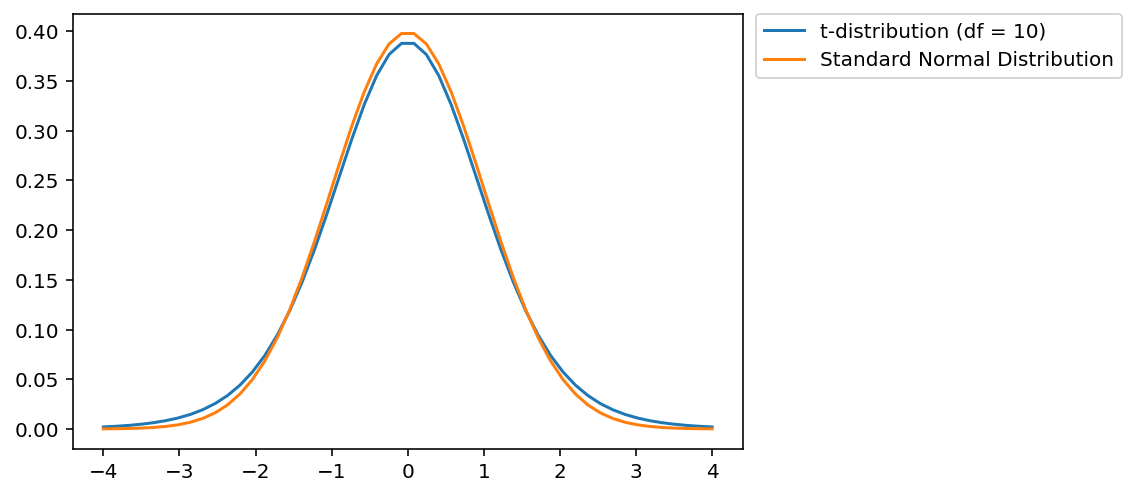

In [34]:
points_pdf =  ss.t.pdf(points, df = 10)
p = plt.plot(points, points_pdf, label = "t-distribution (df = 10)")
p2 = plt.plot(points, points_pdf_norm, label = "Standard Normal Distribution")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

## The role of $n$ 

- For smaller $n$, the *tails* of $t$-distribution are inflated relative to standard normal distribution. 
- As $n \to \infty$, $t$-distribution approximates standard normal distribution.  
- This means the same **value** of $t$ (e.g., $t = 4$) is *differentially likely* given different values of $n$.  

## Check-in: Is an extreme value of $t$ *more* or *less* likely for $n = 5$ vs. $n = 20$? Why?

## Check-in: Is an extreme value of $t$ *more* or *less* likely for $n = 5$ vs. $n = 20$? Why?

**Answer**: Extreme values are *more* likely under the sampling distribution when $n$ is smaller.  

- This is because the *tails* (i.e., extreme values) are **inflated** for smaller values of $n$.  
- On a practical level, this is one reason **sample size** really matters––you're less likely to **miss** a true positive with a larger sample.
 - I.e., less likely to *incorrectly* reject the null.

## So what is the $t$-test?  

The formula ends up quite similar to the $z$-test:

$t_{\bar{X}} = \frac{\bar{X} -\mu}{s_{\bar{X}}}$

Compare to the $z$-test formula:

$z_{\bar{X}} = \frac{\bar{X} -\mu}{\sigma_{\bar{X}}}$

**What's the key difference between these?**

## So what is the $t$-test?  

The formula ends up quite similar to the $z$-test:

$t_{\bar{X}} = \frac{\bar{X} -\mu}{s_{\bar{X}}}$

Compare to the $z$-test formula:

$z_{\bar{X}} = \frac{\bar{X} -\mu}{\sigma_{\bar{X}}}$

**What's the key difference between these?**

- $s$ vs. $\sigma$ for calculating **standard error of the mean** 

## $t$-test in Python

Let's start with a scenario:

> On average, people spend about 150 minutes a day on their iPhone. Suppose that Apple develops a new system to help people monitor and reduce screen time (if they want). A group of 10 participants demos this software, and their screen time is recorded...

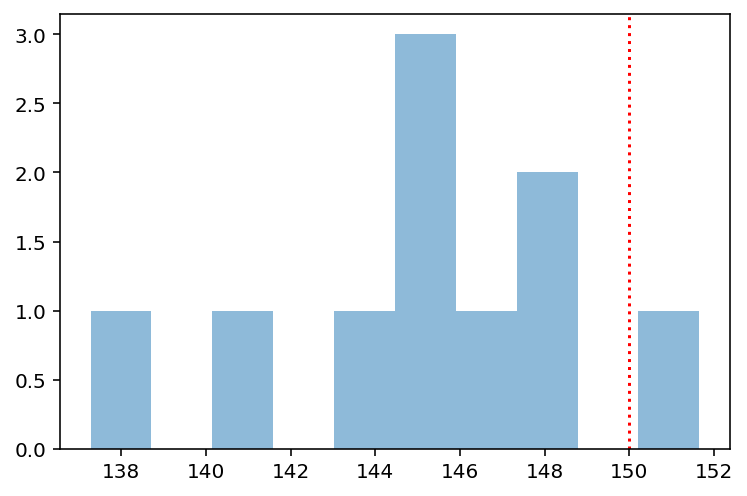

In [82]:
## generate a sample, with mean = 145 and SD = 5
np.random.seed(10)
sample = np.random.normal(loc = 145, scale = 5, size = 10)
p = plt.hist(sample, alpha = .5)
plt.axvline(x = 150, linestyle = "dotted", color = "red")

## $t$-test in Python

Now, we can ask whether the sample **deviates** from the population. For a **one-sample t-test**, we can use:

```
ss.ttest_1samp(
    a = ... # sample observations
    popmean = ... # number indicating population mean
    alternative = ... # two-sided vs. less/greater (i.e. two vs. one tailed)
)
```

In [79]:
t = ss.ttest_1samp(sample, popmean = 150, alternative="less")
print("t = {t}, p = {p}".format(t = round(t.statistic, 2), p = round(t.pvalue, 4)))

t = -3.75, p = 0.0023


## Check-in: Did the software reduce screen time?

# Part 3: Two-sample $t$-tests

- Typically, we're not comparing a **sample** to a **population**.  
- Instead, we're often interested in comparing **two samples**.  
 - **Independent samples**: `Treatment` vs. `Placebo`.
 - **Paired samples**: `Pre` vs. `Post`. 

**Conceptual logic: are these samples drawn from different populations?**

## Independent samples $t$-test

- An **independent samples $t$-test** is used when we're comparing two experimental groups. 
- E.g., two groups of people **randomly** assigned to different conditions

Recall the formula for the one-sample $t$-test:

$t_{\bar{X}} = \frac{\bar{X} -\mu}{s_{\bar{X}}}$

The independent samples $t$-test is conceptually similar:

$t_{\bar{X}} = \frac{\bar{X_1} -\bar{X_2}}{s_{\bar{X}}}$

## A new formula for standard error

The **standard error of the difference between means** is calculated by **pooling the variance** from our two samples.

$s_{\bar{X_1} - \bar{X_2}} = \sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}$

From Witte & Witte (11th edition, pg. 250):

> "...**the value of the new standard error always will be larger than that of the original one**...The original standard error reflects only the variability of single sample means about the mean of their sampling distribution. But the new standard error reflects extra variability when, as a result of random pairings, large differences between pairs of sample means occur, just by chance, because they happen to deviate in opposite directions."

## Independent samples $t$-test in Python

Let's adapt the scenario we used before:

> Apple develops a new software to reduce screen time. They run an experiment, in which 10 participants are assigned to the Control condition (they use their phones as normal), and 10 are assigned to the Treatment condition (they use the new monitoring system). The screen times of both groups are  recorded...

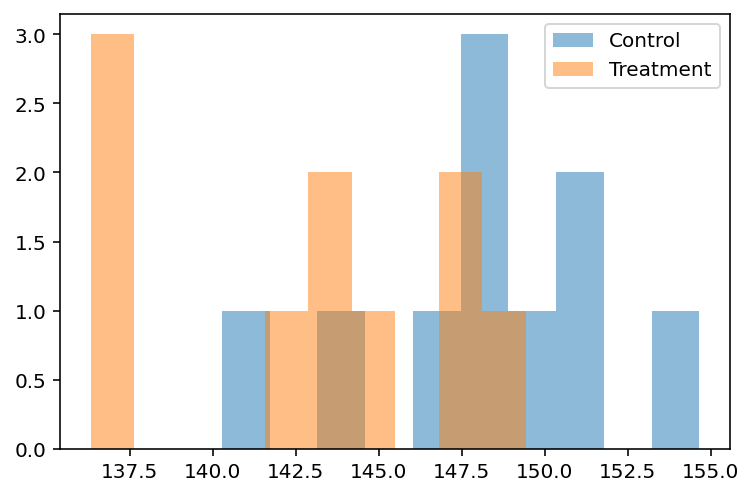

In [83]:
np.random.seed(10)
control = np.random.normal(loc = 148, scale = 5, size = 10)
treatment = np.random.normal(loc = 142, scale = 5, size = 10)
plt.hist(control, label = "Control", alpha = .5)
plt.hist(treatment, label = "Treatment", alpha = .5)
plt.legend()

## Independent samples $t$-test in Python

We can ask whether the samples differ using:

```
scipy.stats.ttest_ind(
    a = .... # group 1
    b = .... # group 2
    alternative = .... # two-sided vs. less vs. greater
)

```

## Check-in: is there a difference between groups?

In [96]:
t = ss.ttest_ind(treatment, control, alternative = "less")
print("t = {t}, p = {p}".format(t = round(t.statistic, 2), p = round(t.pvalue, 4)))

t = -2.75, p = 0.0065


## Paired samples $t$-test

- Often, our study involves some kind of **repeated measure**. 
- E.g., same subjects take a test `before` and `after` an intervention. 
- One advantage of this is we effectively *control* for individual differences. 


### Check-in: should this make the standard error larger or smaller?

## Paired samples $t$-test

Rather than comparing the means of two independent samples, we calculate **within-subject differences** across conditions.

$D = X_1 - X_2$

This allows us to calculate a **mean difference score**:

$\bar{D} = \frac{\sum{D}}{n}$

## Standard error of *difference scores*

- A big advantages of repeated-measures design is that it reduces our variance estimates.  
- In fact, the formula for $\sigma_\bar{D}$ (or $s_\bar{D}$ is more similar to the formulas we use for a z-test or one-sample t-test.

$s_\bar{D} = \frac{s_D}{\sqrt{n}}$

Where $s_D = \sqrt{\frac{SS_{D}}{n-1}}$

## Paired sample $t$-test in Python

Let's adapt our scenario once more:

> Apple develops a new software to reduce screen time. They run an experiment: first, the screen time of 10 participants is measured before using the software. Then, once the software is installed, the screen times for those participants are measured again...

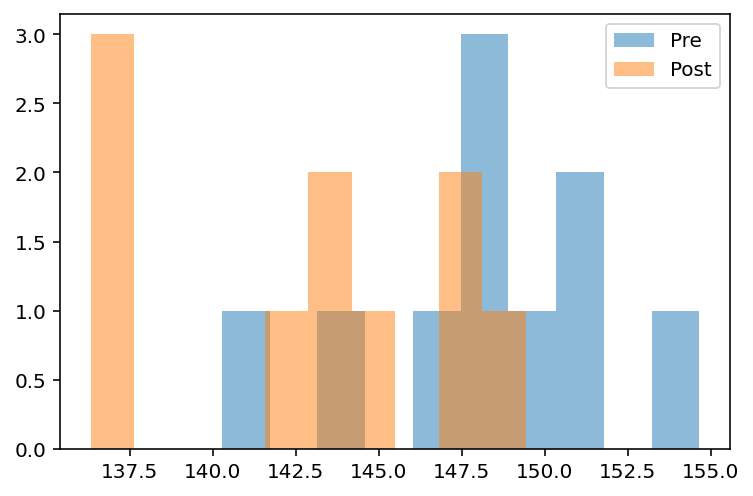

In [94]:
np.random.seed(10)
control = np.random.normal(loc = 148, scale = 5, size = 10)
treatment = np.random.normal(loc = 142, scale = 5, size = 10)
plt.hist(control, label = "Pre", alpha = .5)
plt.hist(treatment, label = "Post", alpha = .5)
plt.legend()

## Independent samples $t$-test in Python

We can ask whether the samples differ using:

```
scipy.stats.ttest_ind(
    a = .... # group 1 (e.g., pre)
    b = .... # group 2 (e.g., post)
    alternative = .... # two-sided vs. less vs. greater
)
```

Note that `a` and `b` *must* have the same shape (e.g., same number of observations).

## Check-in: is there a difference between groups?

In [99]:
t = ss.ttest_rel(treatment, control, alternative = "less")
print("t = {t}, p = {p}".format(t = round(t.statistic, 2), p = round(t.pvalue, 4)))

t = -3.46, p = 0.0036


## Check-in: Is this value of $t$ larger or smaller than when we used independent samples (assuming the same exact numbers?)

## Check-in: Is this value of $t$ larger or smaller than when we used independent samples (assuming the same exact numbers?)

- **Answer**: It's *larger*. 

- This is because the variance estimate in the denominator is *smaller*.  

# Conclusion: NHST in practice

#### Goals for today:

- **Explain** the theoretical foundations of NHST   
- **Implement** a t-test in Python.  
- **Evaluate** the result of a t-test with respect to a research hypothesis.   

#### Other tests

- No time to cover **ANOVA** or **chi-squared test**, etc. 
- But same intuitions apply––in each case, we always want to compare some **test statistic** to a theorized **sampling distribution**. 